In [7]:
from experimenter import *
from utils import *
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm_notebook
from tabulate import tabulate
import sys
lib_path = get_library_path()
sys.path.append(lib_path)
from entropy_estimators.continuous import get_

mcm = mixed_combinations_map
if 'HDPa' in mcm['PA']:
    mcm['PA'].remove('HDPa')

In [352]:
data_name = 'email-Enron'
split_mode = 'structural'
base_path = get_base_path()
params = get_default_params()
params['data_params']['data_name'] = data_name
params['data_params']['split_mode'] = split_mode
params['data_params']['base_path'] = '/home2/e1-313-15477'
dfs = []
i = 0
params['iter_var'] = i
_, lp_results = perform_link_prediction(params['data_params'],
                                        params['lp_data_params'],
                                        params['lp_params'],
                                        params['iter_var'])
df = lp_results['scores']


In [336]:
def get_nbins_dict(df, columns, nbins_base = 3, nbins_count = 7):
    nbins_list = [nbins_base**i for i in range(1, 1+nbins_count)]
    nbins_dict = {}
    for nbins in tqdm_notebook(nbins_list):
        col_mi_dict = {}
        for col in columns:
            df_score = df[[col, 'label']].rename(columns = {col: 'score'})
            scores = list(df_score[df_score['score']>0]['score'])
            try:
                zero_count = df_score['score'].value_counts()[0]
            except KeyError:
                zero_count = 0
            bin_names, bin_ranges = get_log_bins(scores, nbins = nbins)
        #     print(bin_ranges)
            df_score['score'] = df_score['score'].apply(lambda s: bin_names.index(find_bin(s, bin_names, bin_ranges)))

            count_df = df_score.groupby(['label', 'score']).agg(len).reset_index().rename(columns = {0: 'count'})
            from scipy.sparse import csr_matrix
            I = list(map(int, count_df['label']))
            J = list(map(int, count_df['score']))
            V = list(map(int, count_df['count']))
            counts = csr_matrix((V, (I, J))).todense()
            mi = get_mutual_info(counts)
            col_mi_dict[col] = mi
    #         print(col, mi)
        nbins_dict[nbins] = col_mi_dict
    return nbins_dict

In [337]:
mcm

{'AA': ['AA', 'HAAM', 'HAAa', 'HAAl1', 'HAAl2'],
 'AS': ['AS', 'HASM', 'HASa', 'HASl1', 'HASl2'],
 'CN': ['CN', 'HCNM', 'HCNa', 'HCNl1', 'HCNl2'],
 'Cos': ['Cos', 'HCosM', 'HCosa', 'HCosl1', 'HCosl2'],
 'PA': ['PA', 'HPM', 'HPa', 'HPl1', 'HPl2'],
 'JC': ['JC', 'HJCM', 'HJCa', 'HJCl1', 'HJCl2'],
 'Kz': ['Kz', 'HKz'],
 'MxO': ['MxO', 'HmaxoM', 'HmaxoA', 'Hmaxol1', 'Hmaxol2'],
 'MnO': ['MnO', 'HminoM', 'HminoA', 'Hminol1', 'Hminol2'],
 'NM': ['NM', 'HNMM', 'HNMa', 'HNMl1', 'HNMl2'],
 'Prn': ['Prn', 'HPearM', 'HPeara', 'HPearl1', 'HPearl2']}

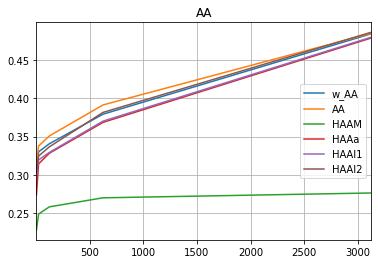

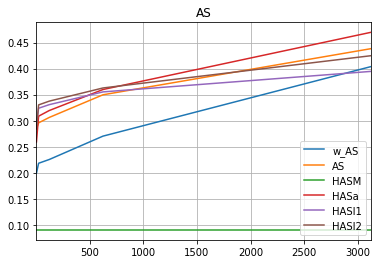

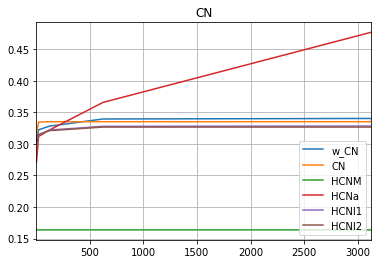

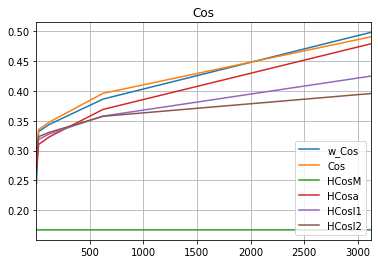

KeyError: 0

In [333]:
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from information_calculator import get_mutual_info
algos = ['AA', 'AS', 'CN', 'Cos', 'PA', 'JC', 'MxO', 'MnO', 'NM', 'Prn']
for algo in algos:
    columns = ['w_{}'.format(algo)] + mcm[algo] 
    if algo == 'PA':
        columns = ['HDPa'] + columns
    nbins_dict = get_nbins_dict(df, columns, nbins_base=5, nbins_count = 5)
    pd.DataFrame(nbins_dict).T.plot(grid = True)
    plt.title(algo)
    plt.show()

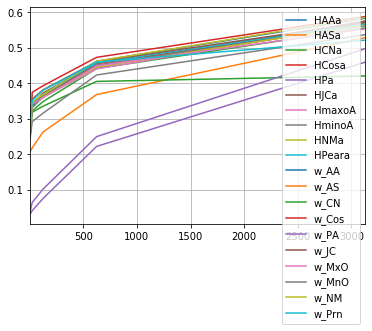

In [353]:
columns = [[y for y in mcm[x] if y.lower().endswith('a')][-1] for x in algos] + ['w_{}'.format(x) for x in algos]
nbins_dict = get_nbins_dict(df, columns, nbins_base=5, nbins_count = 5)
pd.DataFrame(nbins_dict).T.plot(grid = True)
# plt.title(algo)
plt.show()

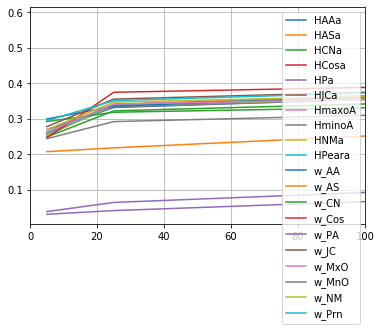

In [354]:
pd.DataFrame(nbins_dict).T.plot(grid = True, xlim = (0, 100))

In [302]:
def find_bin(s, bin_names, bin_ranges):
    if s == 0:
        return bin_names[0]
    for x, rng in zip(bin_names, bin_ranges):
        if x == bin_names[-1]:
            if s >= rng[0]:
                return bin_names[-1]
        if rng[0] <= s < rng[1]:
            return x
    print('Score {} not in any bin: {}'.format(s, bin_ranges))

def get_log_bins(scores, nbins = 5):
    # plt.subplot(211)
    hist, bins = np.histogram(scores, bins=nbins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    # plt.subplot(212)
    loghist, _, = np.histogram(scores, bins=logbins)
#     logbins = bins
    # plt.xscale('log')
    # plt.show()
#     bin_names = ['z', 'vl', 'l', 'm', 'h', 'vh']
    bin_names = list(range(nbins))
    logbins = np.concatenate([[0], logbins])
    bin_ranges = [(logbins[i], logbins[i+1]) for i in range(len(logbins)-1)]
    return bin_names, bin_ranges